In [39]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

from mini_imagenet_dataset import MiniImageNetDataset
from tools import getDataset, print_class_distribution

import numpy as np
from sklearn.model_selection import train_test_split

In [40]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print("MPS device not found.")
print('Device:', device)

Device: mps


In [41]:
batch_size = 128
num_workers = 4
learning_rate = 0.0001 # 0.00005 - the best one so far
num_epochs = 10
num_classes = 5

root_dir = os.path.join(os.getcwd(), 'datasets/EuroSAT_RGB')
dataset, label_mapping = getDataset(path=root_dir, num_classes=num_classes, num_images_per_class=5)


train_transforms = transforms.Compose(
        [
            transforms.RandomCrop(80, padding=8),
            # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
            # transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=5),
            transforms.ToTensor(),
            # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ]
    )

transforms = transforms.Compose(
        [
            transforms.RandomCrop(80, padding=8),
            transforms.ToTensor(),
            # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ]
    )
       
train_dataset, temp_dataset = train_test_split(dataset, test_size=0.3, random_state=42)
val_dataset, test_dataset = train_test_split(temp_dataset, test_size=0.5, random_state=42)
      
train_dataset = MiniImageNetDataset(dataset=train_dataset, path=root_dir, phase='train', transform=transforms)
val_dataset = MiniImageNetDataset(dataset=val_dataset, path=root_dir, phase='val', transform=transforms)
test_dataset = MiniImageNetDataset(dataset=test_dataset, path=root_dir, phase='test', transform=transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

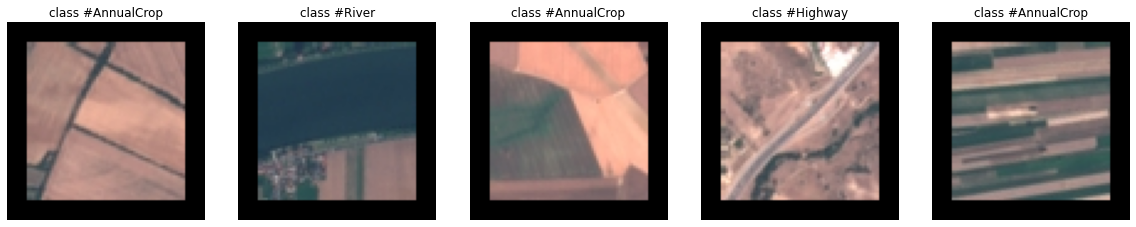

total number of training set: 14
numer of images for class Forest: 3
numer of images for class River: 3
numer of images for class Highway: 3
numer of images for class AnnualCrop: 5


In [42]:
idx = np.random.choice(range(len(train_dataset)), 5, replace=False) # randomly pick 5 pictures to show

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = train_dataset[idx[i]]
    ax = plt.subplot(1, 5, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_mapping[label]))
    ax.axis('off')
    plt.imshow(np.asarray(image.permute(1, 2, 0)))

plt.show()

# print number of images for each class
print('total number of training set: {}'.format(len(train_dataset)))

for i in label_mapping.keys():
    print('numer of images for class {}: {}'.format(label_mapping[i], len([label for _, label in train_dataset.data if label == i])))